In [5]:
import os
import cv2
import pandas as pd
import numpy as np
CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [6]:
def extract_yellow_card(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])  
    upper_yellow = np.array([30, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        yellow_card = img[y:y+h, x:x+w]
        return yellow_card
    else:
        return None  


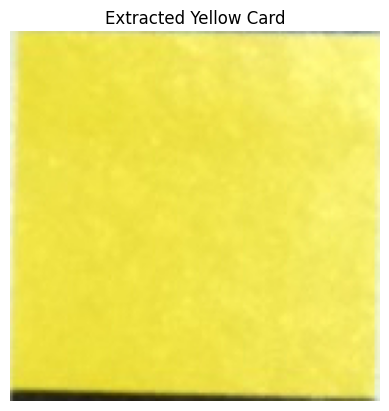

In [7]:
sample_card = extract_yellow_card(image_data[952])
if sample_card is not None:
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(sample_card, cv2.COLOR_BGR2RGB))
    plt.title("Extracted Yellow Card")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not detected in this image.")

In [8]:
def compute_lab_means(lab_img):
    L, A, B = cv2.split(lab_img)
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color(full_img, yellow_card_img):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)
    lab_card = cv2.cvtColor(yellow_card_img, cv2.COLOR_BGR2LAB)
    
    L_card_mean, A_card_mean, B_card_mean = compute_lab_means(lab_card)
    print(L_card_mean, A_card_mean, B_card_mean)
    target_L, target_A, target_B = 190.0, 120.0, 185.0  
    
    delta_L = target_L - L_card_mean
    delta_A = target_A - A_card_mean
    delta_B = target_B - B_card_mean
    
    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)
    
    return corrected_bgr


205.04199803900207 121.601971892363 198.71167883211677


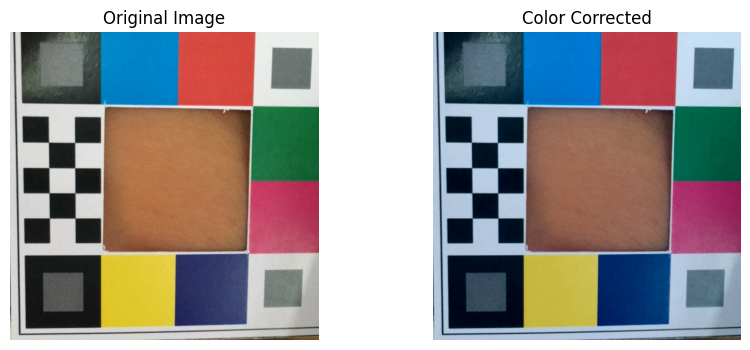

In [9]:
img = image_data[139]
yellow_card = extract_yellow_card(img)
if yellow_card is not None:
    corrected_img = correct_image_color(img, yellow_card)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
    plt.title("Color Corrected")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not found.")


In [10]:
def extract_skin_roi(image, roi_fraction=0.4):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


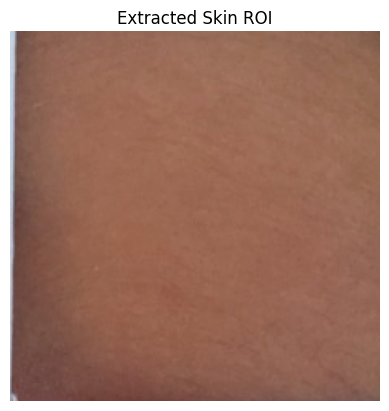

In [11]:
# Assume `corrected_img` is the color corrected image from the previous step
skin_roi = extract_skin_roi(corrected_img, roi_fraction=0.4)

# Optional: visualize to confirm
plt.imshow(cv2.cvtColor(skin_roi, cv2.COLOR_BGR2RGB))
plt.title("Extracted Skin ROI")
plt.axis("off")
plt.show()


In [14]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq


In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    yellow_card = extract_yellow_card(img)
    corrected_img = correct_image_color(img, yellow_card)
    skin_roi = extract_skin_roi(corrected_img)
    return extract_color_spaces(skin_roi)

In [ ]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["blood(mg/dL)"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)


226.0277195085406 117.29013085605834 205.7415343122565
219.56155308838865 115.34024412684782 203.14402257253266
223.1689259645464 116.62559683881236 201.62658470995007
219.74466230936818 115.87233115468409 195.22342047930283
145.87294372294372 134.22857142857143 164.87727272727273
202.07297830374753 109.83481262327416 196.30769230769232
241.62660619803478 110.96452506928698 204.61048122952886
246.7937756899589 110.60945390487375 191.0809747504404
243.524088772054 109.09605176684697 200.5143824882463
226.73453754981625 117.2121525800942 202.22721391232338
219.96728456650737 118.72934936722154 198.3091949797826
210.5319055944056 119.77073620823622 202.29249222999223
227.51638638581187 119.56425414681742 205.5664351718992
195.54359309754994 122.25340846204156 196.60044272274487
207.60744897959182 119.10744897959184 195.249693877551
229.6984126984127 118.04726631393298 204.61334509112288
218.71855706923822 118.89422929741313 200.50176029389254
236.48906203176506 113.62890820097893 200.4948

In [58]:
def flatten_for_scaler(data):
    return data.reshape(data.shape[0], -1)

def reshape_for_cnn(data):
    return data.reshape(data.shape[0], 3,16384)

rgb_flat = flatten_for_scaler(processed_rgb)
hsv_flat = flatten_for_scaler(processed_hsv)
ycbcr_flat = flatten_for_scaler(processed_ycbcr)
lab_flat = flatten_for_scaler(processed_lab)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rgb_flat_scaled = scaler.fit_transform(rgb_flat)
hsv_flat_scaled = scaler.fit_transform(hsv_flat)
ycbcr_flat_scaled = scaler.fit_transform(ycbcr_flat)
lab_flat_scaled = scaler.fit_transform(lab_flat)

rgb_scaled = reshape_for_cnn(rgb_flat_scaled)
hsv_scaled = reshape_for_cnn(hsv_flat_scaled)
ycbcr_scaled = reshape_for_cnn(ycbcr_flat_scaled)
lab_scaled = reshape_for_cnn(lab_flat_scaled)


In [59]:
rgb_scaled.shape

(2231, 3, 16384)

In [60]:
from sklearn.model_selection._split import train_test_split
rgb_train, rgb_temp, hsv_train, hsv_temp, ycbcr_train, ycbcr_temp, lab_train, lab_temp, y_train, y_temp = train_test_split(
    rgb_scaled, hsv_scaled, ycbcr_scaled, lab_scaled, processed_labels, test_size=0.2, random_state=42)

rgb_val,rgb_test,hsv_val, hsv_test, ycbcr_val, ycbcr_test, lab_val, lab_test, y_val, y_test = train_test_split(
    rgb_temp,hsv_temp, ycbcr_temp, lab_temp, y_temp, test_size=0.125, random_state=4)

In [61]:
rgb_train.shape

(1784, 3, 16384)

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_rgb_1d_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling1D(pool_size=2 , padding='same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))  

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_shape = rgb_train.shape[1:]  
model = build_rgb_1d_cnn(input_shape)
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 3, 32)             1572896   
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 2, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_36 (Conv1D)          (None, 2, 64)             6208      
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_37 (Conv1D)          (None, 1, 128)            24704     
                                                                 
 max_pooling1d_33 (MaxPooli  (None, 1, 128)          

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)
]
history = model.fit(
    rgb_train, y_train,
    validation_data=(rgb_val, y_val),
    epochs=150,
    batch_size=32,
    verbose=2,
    callbacks=callbacks
)


Epoch 1/150
56/56 - 2s - loss: 19.1421 - mae: 3.4864 - val_loss: 17.8281 - val_mae: 3.3802 - lr: 0.0010 - 2s/epoch - 41ms/step
Epoch 2/150
56/56 - 3s - loss: 18.0079 - mae: 3.3502 - val_loss: 18.1143 - val_mae: 3.3969 - lr: 0.0010 - 3s/epoch - 50ms/step
Epoch 3/150
56/56 - 2s - loss: 18.2921 - mae: 3.3843 - val_loss: 15.5939 - val_mae: 3.1697 - lr: 0.0010 - 2s/epoch - 35ms/step
Epoch 4/150
56/56 - 2s - loss: 18.0986 - mae: 3.3719 - val_loss: 15.5307 - val_mae: 3.1491 - lr: 0.0010 - 2s/epoch - 40ms/step
Epoch 5/150
56/56 - 2s - loss: 18.7997 - mae: 3.4415 - val_loss: 15.9263 - val_mae: 3.1757 - lr: 0.0010 - 2s/epoch - 39ms/step
Epoch 6/150
56/56 - 2s - loss: 18.1202 - mae: 3.3993 - val_loss: 15.7531 - val_mae: 3.1489 - lr: 0.0010 - 2s/epoch - 35ms/step
Epoch 7/150
56/56 - 2s - loss: 17.8222 - mae: 3.3285 - val_loss: 16.2830 - val_mae: 3.1508 - lr: 0.0010 - 2s/epoch - 37ms/step
Epoch 8/150
56/56 - 2s - loss: 19.0377 - mae: 3.4419 - val_loss: 15.5529 - val_mae: 3.1541 - lr: 0.0010 - 2s/ep

In [76]:
test_loss, test_mae = model.evaluate(rgb_test, y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict to calculate R^2 or RMSE if needed
from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict(rgb_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"R^2: {r2:.3f}")


2/2 - 0s - loss: 19.7476 - mae: 3.3956 - 19ms/epoch - 9ms/step
Test Loss (MSE): 19.74761962890625
Test MAE: 3.395639657974243
2/2 [==============================] - 0s 3ms/step
RMSE: 4.444
R^2: 0.346
